# Calculate Molecular Descriptors for SMILES Using RDKit

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

# Load the dataset
data = pd.read_csv('LZ_Ligands_0925_only14_dr_onlyL.csv')

# Define a function to calculate molecular descriptors for a SMILES string
def calc_descriptors(smiles, suffix):
    mol = Chem.MolFromSmiles(smiles)
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(mol)
    # Convert the result to a dictionary with suffixes
    return {f"{name}_{suffix}": value for name, value in zip(descriptor_names, descriptors)}

# Initialize an empty list to store the computed descriptors
descriptor_data = []

# Iterate over each row in the data to compute descriptors for each molecule
for index, row in data.iterrows():
    ligand_descriptors = calc_descriptors(row['Ligand'], 'L')
    
    # Combine the computed descriptors with the original data
    combined_data = {**ligand_descriptors, 'Ligand ID': row['Ligand ID'], 'ln(dr)': row['ln(dr)']}
    descriptor_data.append(combined_data)

# Convert the result to a DataFrame
descriptor_df = pd.DataFrame(descriptor_data)

# Save the descriptor data to a CSV file
descriptor_df.to_csv('molecular_descriptors.csv', index=False)


# Feature Selection and Data Cleaning

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

# Check and remove columns with NaN values
print("Data shape before cleaning:", descriptor_df.shape)

# Check if there are any NaN values
print("Are there NaN values:", descriptor_df.isnull().values.any())

# Remove columns containing NaN values
descriptor_df_clean = descriptor_df.dropna(axis=1)

# Check again if there are any NaN values
print("Data shape after removing NaN columns:", descriptor_df_clean.shape)
print("Are there still NaN values:", descriptor_df_clean.isnull().values.any())

# Store 'Ligand ID' separately for later merging
ligand_id = descriptor_df_clean['Ligand ID']

# Split data into features and target (excluding 'Ligand ID')
X = descriptor_df_clean.drop(columns=['Ligand ID', 'ln(dr)'])
y = descriptor_df_clean['ln(dr)']

# Check if there are still NaN values in features and target
print("Are there NaN values in features X:", X.isnull().values.any())
print("Are there NaN values in target y:", y.isnull().values.any())

# Check for features with zero variance
zero_variance = X.var() == 0
print(f"Features with zero variance: {X.columns[zero_variance]}")

# Remove features with zero variance
X_non_zero_var = X.loc[:, X.var() != 0]

print(f"Data shape after removing zero variance features: {X_non_zero_var.shape}")

# Use SelectKBest to select the 20 most important features
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X_non_zero_var, y)

# Get the names of the selected features
selected_features = X_non_zero_var.columns[selector.get_support()]

# Build a new DataFrame to save the selected features
selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Add 'Ligand ID' and target variable back
selected_df['Ligand ID'] = ligand_id.values  # Add back 'Ligand ID' column
selected_df['ln(dr)'] = y.values  # Add target variable

# Save the selected features
selected_df.to_csv('selected_features.csv', index=False)
X = selected_df.drop(columns=['Ligand ID', 'ln(dr)'])

# Print relevant information
print(f"Shape of data after feature selection: {X.shape}")
print(f"Shape of data after feature selection: {selected_df.shape}")
print(f"Selected features: {selected_features}")


Data shape before cleaning: (86, 212)
Are there NaN values: True
Data shape after removing NaN columns: (86, 204)
Are there still NaN values: False
Are there NaN values in features X: False
Are there NaN values in target y: False
Features with zero variance: Index(['SMR_VSA2_L', 'SMR_VSA8_L', 'SlogP_VSA7_L', 'SlogP_VSA9_L',
       'EState_VSA11_L', 'VSA_EState10_L', 'fr_Al_COO_L', 'fr_Al_OH_L',
       'fr_Al_OH_noTert_L', 'fr_ArN_L', 'fr_Ar_COO_L', 'fr_Ar_OH_L',
       'fr_COO_L', 'fr_COO2_L', 'fr_C_S_L', 'fr_HOCCN_L', 'fr_NH2_L',
       'fr_N_O_L', 'fr_Ndealkylation2_L', 'fr_SH_L', 'fr_aldehyde_L',
       'fr_alkyl_carbamate_L', 'fr_amide_L', 'fr_azide_L', 'fr_azo_L',
       'fr_barbitur_L', 'fr_benzodiazepine_L', 'fr_diazo_L',
       'fr_dihydropyridine_L', 'fr_epoxide_L', 'fr_furan_L', 'fr_guanido_L',
       'fr_hdrzine_L', 'fr_hdrzone_L', 'fr_imidazole_L', 'fr_imide_L',
       'fr_isocyan_L', 'fr_isothiocyan_L', 'fr_ketone_L',
       'fr_ketone_Topliss_L', 'fr_lactam_L', 'fr_lacton

# Machine Learning Model Training and Evaluation Using Cross-Validation

In [7]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np

# Standardize the data
scaler = StandardScaler()

# Define the list of models to be tested, using a pipeline to combine standardization and model training
models = {
    'LinearRegression': make_pipeline(StandardScaler(), LinearRegression()),
    'Ridge': make_pipeline(StandardScaler(), Ridge(alpha=1.0, max_iter=5000)),
    'Lasso': make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=5000)),
    'ElasticNet': make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, max_iter=5000)),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'SVR': make_pipeline(StandardScaler(), SVR()),
    'KNeighbors': make_pipeline(StandardScaler(), KNeighborsRegressor()),
    'DecisionTree': DecisionTreeRegressor(),
    'MLP': make_pipeline(StandardScaler(), MLPRegressor(max_iter=1000)),
    'XGBoost': XGBRegressor(),
    'GaussianProcess': GaussianProcessRegressor()
}

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=40)

# Custom scoring metrics
scorers = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Initialize a dictionary to store the cross-validation results for each model
results = {}

# Train and evaluate each model using 5-fold cross-validation
for name, model in models.items():
    print(f"Training model: {name}")
    
    # Perform 5-fold cross-validation and calculate the average MSE, MAE, and R2
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=scorers['MSE'])
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring=scorers['MAE'])
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=scorers['R2'])
    
    # Calculate Root Mean Square Error (RMSE)
    rmse_scores = np.sqrt(mse_scores)
    
    # Calculate the average value for each metric
    results[name] = {
        'MSE': np.mean(mse_scores),
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'R2': np.mean(r2_scores)
    }
    
    print(f"{name}: MSE = {np.mean(mse_scores)}, RMSE = {np.mean(rmse_scores)}, MAE = {np.mean(mae_scores)}, R2 = {np.mean(r2_scores)}")

# Output the results as a DataFrame
results_df = pd.DataFrame(results).T  # Transpose to make model names as row labels
print(results_df)

# Save the model evaluation results to a CSV file
results_df.to_csv('model_comparison_cross_validation_results.csv', index=True)


Training model: LinearRegression
LinearRegression: MSE = 4.5748802338179635, RMSE = 1.836837451914223, MAE = 0.9925582973141334, R2 = -0.8114297509492993
Training model: Ridge
Ridge: MSE = 0.5922052741728306, RMSE = 0.7602532382621845, MAE = 0.5498649027381626, R2 = 0.671545862741404
Training model: Lasso
Lasso: MSE = 0.5550672746888673, RMSE = 0.7337448223997516, MAE = 0.532123819508283, R2 = 0.6952760080548136
Training model: ElasticNet
ElasticNet: MSE = 0.5848154213988227, RMSE = 0.7538993998827694, MAE = 0.5473592113445875, R2 = 0.6759055162748734
Training model: RandomForest
RandomForest: MSE = 0.3370202399673203, RMSE = 0.574593775903589, MAE = 0.4323502614379084, R2 = 0.7871946474109779
Training model: GradientBoosting
GradientBoosting: MSE = 0.3303420269629789, RMSE = 0.5703410402292518, MAE = 0.403186633513697, R2 = 0.799616162823867
Training model: AdaBoost
AdaBoost: MSE = 0.3467718335968609, RMSE = 0.5794522475130582, MAE = 0.47450207172836534, R2 = 0.7711094887383994
Traini

# Feature Importance and Cross-Validation with ExtraTreesRegressor

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('selected_features.csv')

# Data preprocessing
X = data.drop(columns=['Ligand ID', 'ln(dr)'])  # Features are descriptors, remove ID and ln(dr)
y = data['ln(dr)']  # Target variable is ln(dr)

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mse, r2

# Initialize ExtraTreesRegressor model
et = ExtraTreesRegressor(random_state=42)

# Fit the model and obtain feature importances
et.fit(X_scaled, y)
importances = et.feature_importances_

# Rank the features by importance
indices = np.argsort(importances)[::-1]

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store true and predicted values for each fold
y_true_all = []
y_pred_all = []

# List to store results
results = []

# Incrementally train with an increasing number of top features (from 1 to 20)
for i in range(1, 21):
    selected_features = X_scaled[:, indices[:i]]  # Select the top i most important features
    
    maes, rmses, mses, r2s = [], [], [], []
    
    # 5-fold cross-validation
    for train_index, test_index in kf.split(selected_features):
        X_train, X_test = selected_features[train_index], selected_features[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        et.fit(X_train, y_train)
        y_pred = et.predict(X_test)
        
        # Evaluate the model
        mae, rmse, mse, r2 = evaluate_model(y_test, y_pred)
        maes.append(mae)
        rmses.append(rmse)
        mses.append(mse)
        r2s.append(r2)
        
        # Combine true and predicted values
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    # Calculate average evaluation metrics
    results.append({
        'n_features': i,
        'MAE': np.mean(maes),
        'RMSE': np.mean(rmses),
        'MSE': np.mean(mses),
        'R2': np.mean(r2s)
    })

# Convert results to a DataFrame and sort
results_df = pd.DataFrame(results)

# Print the best result based on the highest R²
best_result = results_df.loc[results_df['R2'].idxmax()]
print("Best result based on R²:")
print(best_result)
best_n_features = int(best_result['n_features'])

# Show all evaluation results for each feature combination
print("Evaluation results for all feature combinations:")
print(results_df)


Best result based on R²:
n_features    8.000000
MAE           0.408906
RMSE          0.554975
MSE           0.335823
R2            0.839826
Name: 7, dtype: float64
Evaluation results for all feature combinations:
    n_features       MAE      RMSE       MSE        R2
0            1  0.676381  0.833901  0.741029  0.656444
1            2  0.618936  0.798612  0.691726  0.693623
2            3  0.543122  0.729326  0.582746  0.742768
3            4  0.512936  0.684346  0.512838  0.776143
4            5  0.462950  0.614778  0.435955  0.812974
5            6  0.441625  0.579056  0.388634  0.830029
6            7  0.425187  0.578922  0.380254  0.826223
7            8  0.408906  0.554975  0.335823  0.839826
8            9  0.458085  0.624814  0.449645  0.801655
9           10  0.457606  0.614000  0.422030  0.810477
10          11  0.459987  0.623123  0.439430  0.804981
11          12  0.468349  0.634011  0.447493  0.795681
12          13  0.457923  0.623030  0.429040  0.805223
13          14  0

# Visualization of Feature Importance and Model Evaluation

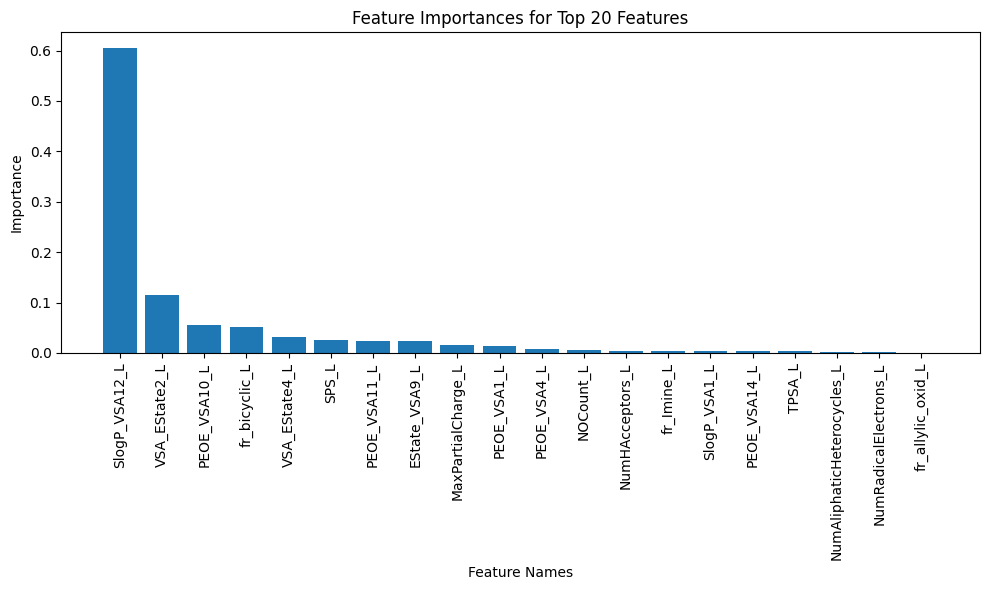

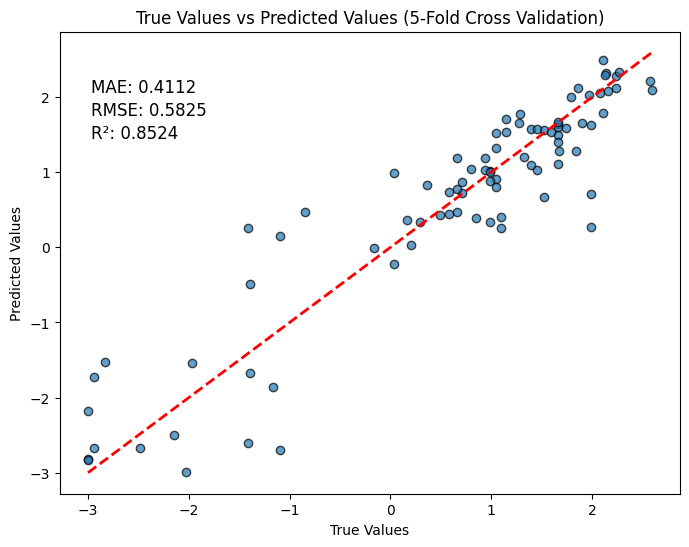

Data has been saved to 'true_vs_predicted_values.csv'


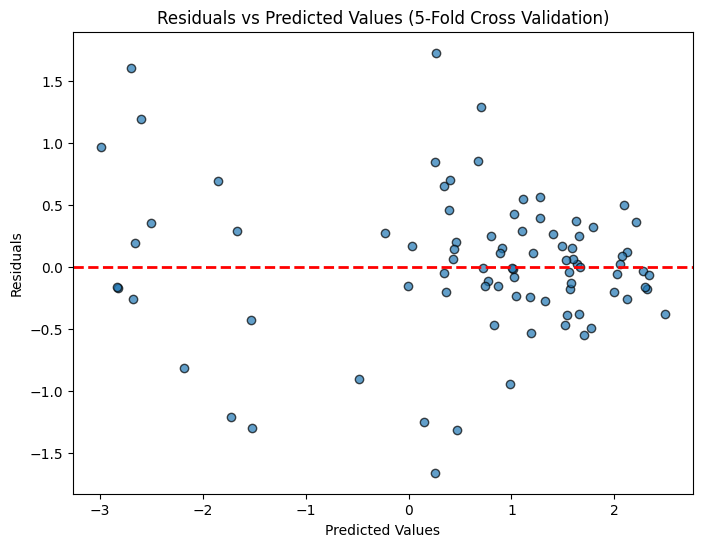

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Retrieve feature names
feature_names = X.columns

# Reorder feature names to align with the importance ranking
sorted_feature_names = feature_names[indices]

# 1. Visualizing Feature Importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importances for Top 20 Features')

# Plot the bar chart with X-axis showing feature names
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), sorted_feature_names[:20], rotation=90)  # Use feature names instead of indices
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Use the optimal number of features for 5-fold cross-validation and combine predictions
selected_features_optimal = X_scaled[:, indices[:best_n_features]]

# Store the true and predicted values for each fold
y_true_all = []
y_pred_all = []

# 5-fold cross-validation
for train_index, test_index in kf.split(selected_features_optimal):
    X_train, X_test = selected_features_optimal[train_index], selected_features_optimal[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    et.fit(X_train, y_train)
    
    # Predict
    y_pred = et.predict(X_test)
    
    # Combine true and predicted values
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Convert y_true_all and y_pred_all to NumPy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Calculate evaluation metrics for cross-validation
mae_cv, rmse_cv, mse_cv, r2_cv = evaluate_model(y_true_all, y_pred_all)

# Plot a comparison of true vs predicted values, and add evaluation metrics
plt.figure(figsize=(8, 6))
plt.scatter(y_true_all, y_pred_all, edgecolor='k', alpha=0.7)
plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--', lw=2)
plt.title('True Values vs Predicted Values (5-Fold Cross Validation)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Add evaluation metrics to the plot
plt.text(0.05, 0.9, f'MAE: {mae_cv:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f'RMSE: {rmse_cv:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.80, f'R²: {r2_cv:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

# Create a DataFrame with true and predicted values
results_df = pd.DataFrame({
    'True_Values': y_true_all,
    'Predicted_Values': y_pred_all
})

# Save the DataFrame to a CSV file
results_df.to_csv('true_vs_predicted_values.csv', index=False)

print("Data has been saved to 'true_vs_predicted_values.csv'")

# 3. Residual Plot (Based on 5-fold cross-validation)
residuals = y_true_all - y_pred_all
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_all, residuals, edgecolor='k', alpha=0.7)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Values (5-Fold Cross Validation)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


# SHAP Feature Importance, Distribution, and Dependence Plots

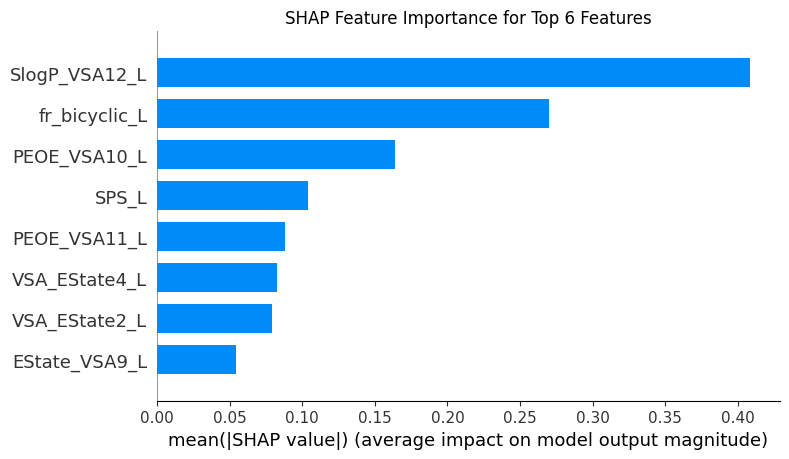

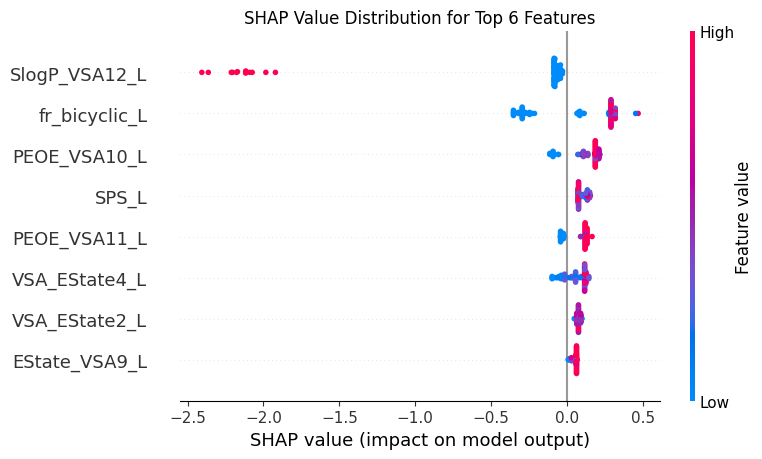

<Figure size 1000x600 with 0 Axes>

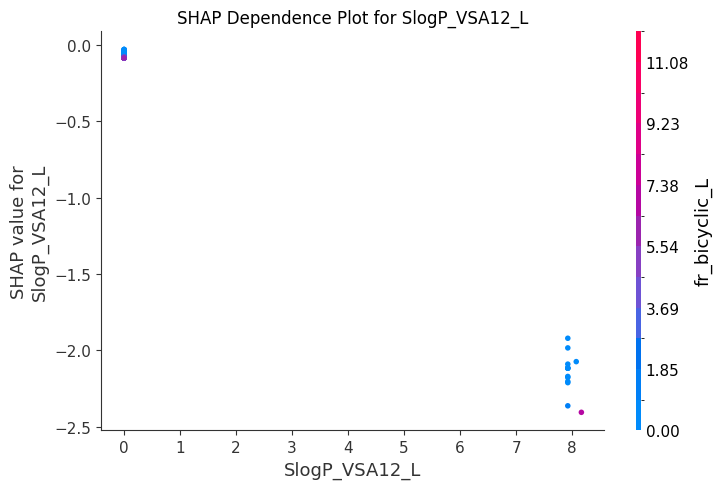

<Figure size 1000x600 with 0 Axes>

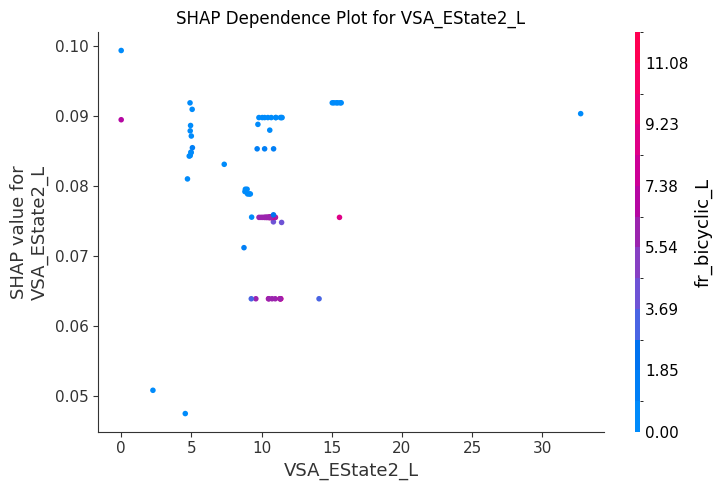

<Figure size 1000x600 with 0 Axes>

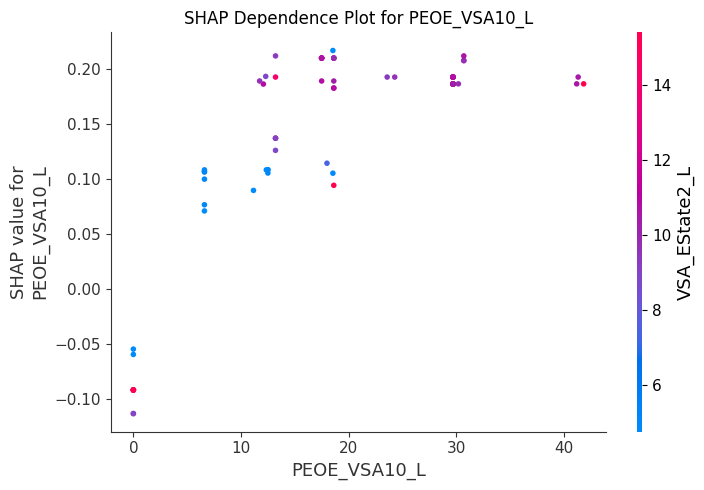

<Figure size 1000x600 with 0 Axes>

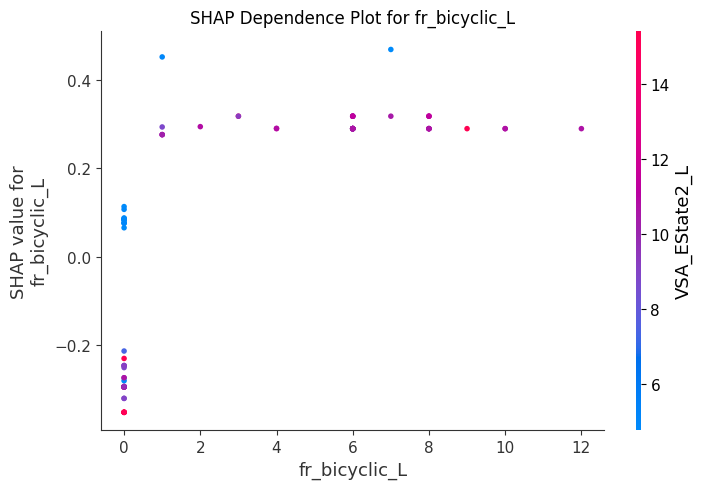

<Figure size 1000x600 with 0 Axes>

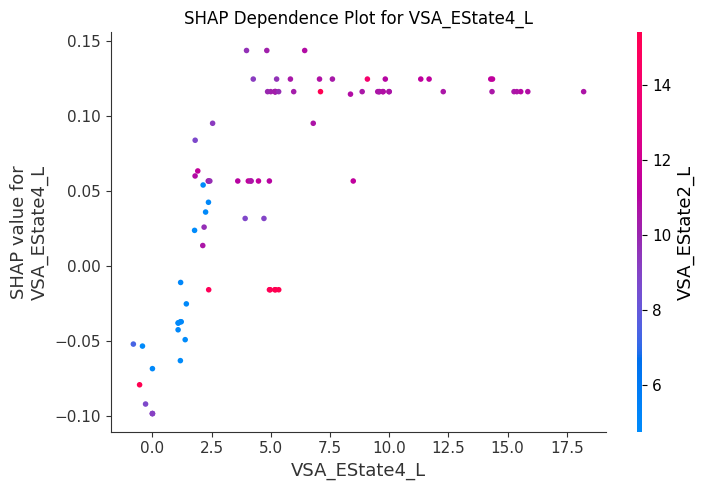

<Figure size 1000x600 with 0 Axes>

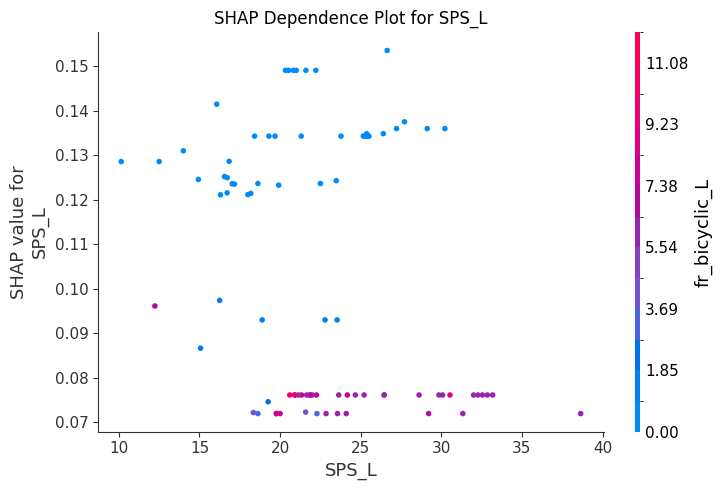

<Figure size 1000x600 with 0 Axes>

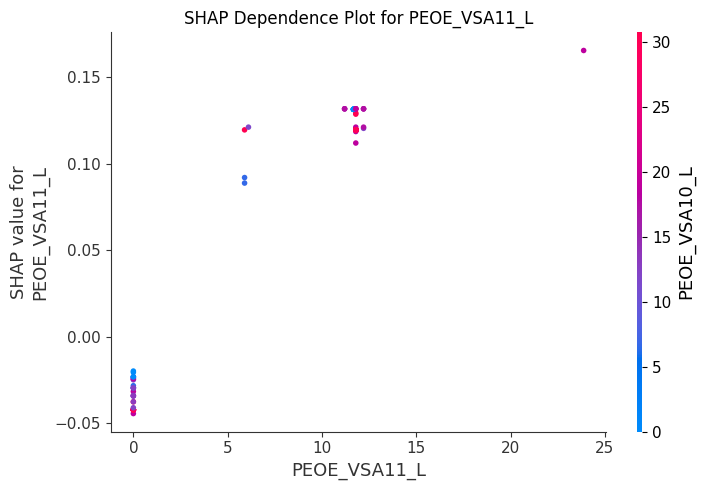

<Figure size 1000x600 with 0 Axes>

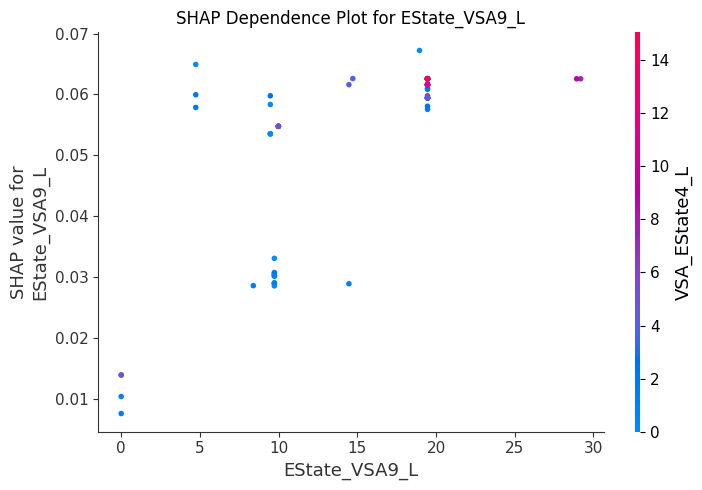

In [15]:
import shap
import matplotlib.pyplot as plt

# Assuming X is your feature dataset and et is your trained ExtraTreesRegressor model

# Select the top 8 most important features
top_8_features = X.columns[indices[:8]]
X_top_8 = X[top_8_features]

# Create a SHAP explainer
explainer = shap.TreeExplainer(et)

# Calculate SHAP values
shap_values = explainer.shap_values(X_top_8)

# Plot SHAP summary (bar chart)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_top_8, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Top 6 Features")
plt.tight_layout()
plt.show()

# Plot SHAP value distribution
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_top_8, show=False)
plt.title("SHAP Value Distribution for Top 6 Features")
plt.tight_layout()
plt.show()

# Plot SHAP dependence plot for each feature
for feature in top_8_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_top_8, show=False)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()


# Bar Chart of Feature Importance Based on SHAP Values

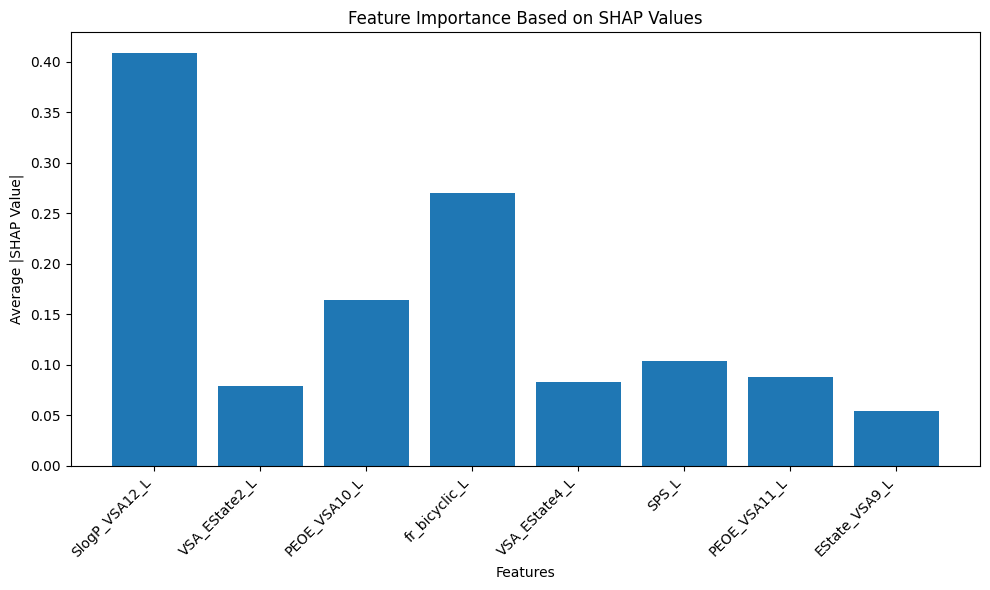

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean absolute SHAP value for each feature
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(X_top_8.columns, feature_importance)
plt.title("Feature Importance Based on SHAP Values")
plt.xlabel("Features")
plt.ylabel("Average |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
